In [100]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")


In [101]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

In [102]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [116]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm=ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.5
)

In [104]:
tavily.invoke("DY Patil college of Engineering,kolhapur ")

[{'url': 'https://collegedunia.com/college/13305-dy-patil-college-of-engineering-and-technology-dypcet-kolhapur',
  'content': '| **Particular** | **Details** |\n| --- | --- |\n| Name of College | D.Y. Patil College of Engineering and Technology, Kolhapur |\n| Established | 1984 |\n| Location | Kolhapur, Maharashtra |\n| Accredited By | NAAC ‘A’ (CGPA 3.08), NBA (CSE, ECE, Mechanical) |\n| Approved By | AICTE, UGC |\n| Affiliated To | Shivaji University, Kolhapur |\n| Ranking | India Today 2024: 192 (B.Tech), 22 (B.Arch) |\n| Admission Criteria | Entrance-Based |\n| Entrance Exams | MHT-CET, JEE Main, NATA, GATE | [...] **DYPCET (D.Y. Patil College of Engineering and Technology), Kolhapur,** has been operating since **1984** as an **autonomous institution** affiliated with **Shivaji University**, Kolhapur. DY Patil Kolhapur is **NAAC** accredited with an ‘**A’ grade** and accredited by **NBA.** [...] \n\n\n\n'},
 {'url': 'https://en.wikipedia.org/wiki/D._Y._Patil_College_of_Engineering

In [105]:
tools=[tavily,arxiv_tool,wiki_tool]


In [106]:
llm_with_tool=llm.bind_tools(tools=tools)

In [107]:
llm_with_tool.invoke("who is Sharukh Khan")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "Sharukh Khan"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ad9e07dd-d08a-44a7-b4d1-9cdc4ccbb030-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Sharukh Khan'}, 'id': 'b70fd92c-a4af-4cbb-a1a6-c9ef13412d65', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 5, 'total_tokens': 167, 'input_token_details': {'cache_read': 0}})

In [108]:
from typing import TypedDict,Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph,START,END,add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [109]:
class state(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [110]:
def tool_calling_llm(state:state):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

In [111]:
builder=StateGraph(state)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)

builder.add_edge("tools",END)
graph=builder.compile()

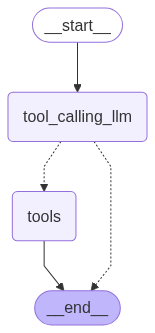

In [112]:
from IPython.display import Image, display


# Display the graph visualization
display(Image(graph.get_graph().draw_mermaid_png()))

In [115]:
message = graph.invoke({"messages": "one latest news for iit in short"})

for m in message["messages"]:
    m.pretty_print()

================================ Human Message =================================

one latest news for iit in short
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (dc9f17a7-dce1-4729-be48-739c0dc5a597)
 Call ID: dc9f17a7-dce1-4729-be48-739c0dc5a597
  Args:
    query: latest news for IIT
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.thehindu.com/tag/iit/", "content": "### [Cabinet allocate more funds to five IITs, new scheme for ITIs](https://www.thehindu.com/news/national/cabinet-allocate-more-funds-to-five-iits-new-scheme-for-itis/article69549989.ece)\n\n### [Centre asks coaching centres to stop misleading students and adhere to guidelines](https://www.thehindu.com/news/national/consumer-protection-authority-warns-coaching-centres-against-misleading-ads-ahead-of-iit-jee-results/article69460026.ece) [...] ### [10th internat

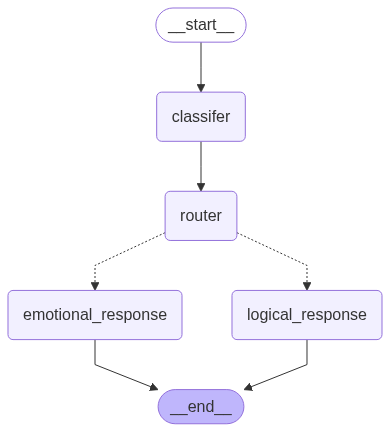

In [117]:
from langgraph.graph import StateGraph,START,END,add_messages
from typing import TypedDict,Annotated,Literal
from pydantic import BaseModel,Field
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI
llm=ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.5
)

class messages_classifer(BaseModel):
    messages_type:Literal["Logical","emotional"]=Field(description="Classify if the message requires an emotional (therapist) or logical response.")
    

class state(TypedDict):
    messages: Annotated[list, add_messages]
    messages_type:str |None
    next:str |None

def classifer(state:state):
    model=llm.with_structured_output(messages_classifer)
    last_msg=state["messages"][-1]
    responce=model.invoke([
        {"role":"user","content":last_msg.content},
        {"role":"system","content":"""Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        }
    ]

    )
    print(responce.messages_type)
    return {"messages_type":responce.messages_type}


def router(state:state):
    message_type=state.get("messages_type","Logical")
    if message_type=="emotional":
        return {"next":"emotional_response"}
    else:
        return {"next":"logical_response"}


def Logical_responce(state:state):
    last_message=state["messages"][-1]
    responce=llm.invoke([
        {"role":"system","content":"""
            You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked.
        """},
        {"role":"user","content":last_message.content}
    ])
    return {"messages":[{"role":"Assistant","content":responce.content}]}


def therapist_agent(state: state):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}



graph=StateGraph(state)

graph.add_node("classifer",classifer)
graph.add_node("router",router)
graph.add_node("logical_response",Logical_responce)
graph.add_node("emotional_response",therapist_agent)
graph.add_edge(START,"classifer")
graph.add_edge("classifer","router")
graph.add_conditional_edges("router",
                            lambda state:state.get("next"),
                            {"emotional_response":"emotional_response",
                             "logical_response":"logical_response"}
                            )
graph.add_edge("logical_response",END)
graph.add_edge("emotional_response",END)

graph_compiled=graph.compile()


from IPython.display import Image, display


# Display the graph visualization
display(Image(graph_compiled.get_graph().draw_mermaid_png()))